In [6]:
import geopandas as gpd
import pyogrio as ogr
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString, Point, Polygon
import pandas as pd
%pip install requests
import requests
%pip install networkx
import networkx as nx
%pip install osmnx
import osmnx as ox
%pip install h3
import h3
%pip install libpysal
import libpysal as lps

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached beautifulsoup4-4.12.3-py3-none-any.whl.metadata (3.8 kB)
  Using cached soupsieve-2.5-py3-none-any.whl.metadata (4.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 9.1 MB/s eta 0:00:00a 0:00:01
Using cached beautifulsoup4-4.12.3-py3-none-any.whl (147 kB)
Using cached soupsieve-2.5-py3-none-any.whl (36 kB)
Note: you may need to restart the kernel to use updated packages.


In [7]:
# bounding box of nyc
bbox = (-74.3, 40.5, -73.7, 40.9)

In [8]:
# create a geodataframe of 100 random points
np.random.seed(0)
n = 100
df = pd.DataFrame(
    {
        "geometry": gpd.points_from_xy(
            np.random.uniform(-74.3, -73.7, n),
            np.random.uniform(40.5, 40.9, n),
        ),
    }
)

In [9]:
gdf = gpd.GeoDataFrame(df, crs="EPSG:4326")

<Axes: >

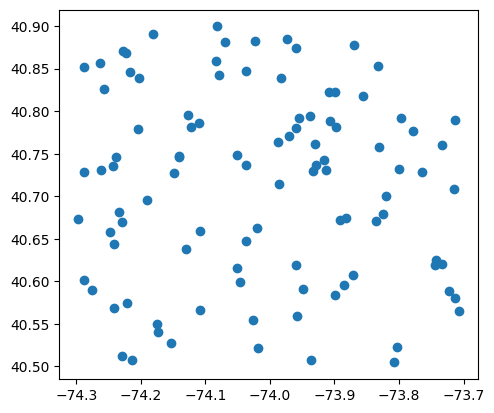

In [10]:
gdf.plot()

In [11]:
# find five nearest neighbors for each point, not including itself
k = 5
neighbors = gdf.geometry.apply(lambda x: gdf.geometry.distance(x)).values.argsort(
    axis=1
)[:, 1 : k + 1]

# join neighbors to original dataframe
gdf["neighbors"] = neighbors.tolist()

/var/folders/p0/n4n30xss14l6w70vvb2pzcd40000gn/T/ipykernel_56457/2007509322.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  neighbors = gdf.geometry.apply(lambda x: gdf.geometry.distance(x)).values.argsort(


In [12]:
gdf

,geometry,neighbors
0,POINT (-73.97071 40.77113),"[12, 28, 88, 2, 37]"
1,POINT (-73.87089 40.608),"[83, 91, 42, 39, 31]"
2,POINT (-73.93834 40.79408),"[88, 12, 62, 37, 0]"
3,POINT (-73.97307 40.88488),"[84, 11, 22, 51, 56]"
4,POINT (-74.04581 40.5995),"[29, 41, 32, 58, 80]"
...,...,...
95,POINT (-74.19009 40.69618),"[61, 24, 57, 87, 15]"
96,POINT (-73.94809 40.59097),"[33, 50, 91, 83, 1]"
97,POINT (-74.28794 40.60174),"[75, 69, 67, 15, 92]"
98,POINT (-73.80264 40.52321),"[66, 8, 52, 72, 1]"


In [13]:
def create_lines(r):
    lines = []
    for i, neighbor in enumerate(r.neighbors):
        lines.append(LineString([r.geometry, gdf.loc[neighbor].geometry]))
    return MultiLineString(lines)

In [14]:
gdf["line_geometry"] = gdf.apply(create_lines, axis=1)

In [15]:
gdf

,geometry,neighbors,line_geometry
0,POINT (-73.97071 40.77113),"[12, 28, 88, 2, 37]","MULTILINESTRING ((-73.97071 40.77113, -73.9591..."
1,POINT (-73.87089 40.608),"[83, 91, 42, 39, 31]","MULTILINESTRING ((-73.87089 40.608, -73.88452 ..."
2,POINT (-73.93834 40.79408),"[88, 12, 62, 37, 0]","MULTILINESTRING ((-73.93834 40.79408, -73.9544..."
3,POINT (-73.97307 40.88488),"[84, 11, 22, 51, 56]","MULTILINESTRING ((-73.97307 40.88488, -73.9600..."
4,POINT (-74.04581 40.5995),"[29, 41, 32, 58, 80]","MULTILINESTRING ((-74.04581 40.5995, -74.0512 ..."
...,...,...,...
95,POINT (-74.19009 40.69618),"[61, 24, 57, 87, 15]","MULTILINESTRING ((-74.19009 40.69618, -74.2337..."
96,POINT (-73.94809 40.59097),"[33, 50, 91, 83, 1]","MULTILINESTRING ((-73.94809 40.59097, -73.9589..."
97,POINT (-74.28794 40.60174),"[75, 69, 67, 15, 92]","MULTILINESTRING ((-74.28794 40.60174, -74.2764..."
98,POINT (-73.80264 40.52321),"[66, 8, 52, 72, 1]","MULTILINESTRING ((-73.80264 40.52321, -73.8074..."


In [16]:
lines_gdf = gpd.GeoDataFrame(
    gdf[["line_geometry"]], geometry="line_geometry", crs="EPSG:4326"
)

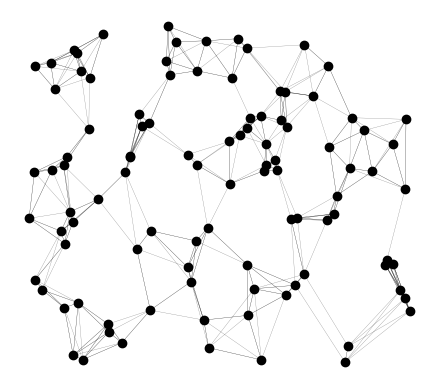

In [17]:
ax = lines_gdf.plot(color="black", alpha=0.5, linewidth=0.2)
gdf.plot(ax=ax, color="black").set_axis_off()
plt.savefig("lines.pdf", bbox_inches="tight", pad_inches=0)

<Axes: >

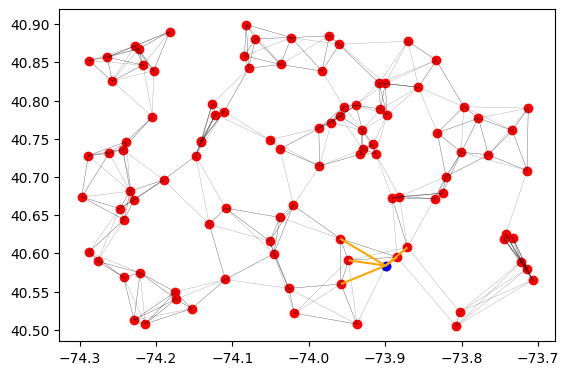

In [18]:
# plot the lines for a single point
s = gdf.sample(1)
ax = lines_gdf.plot(color="black", alpha=0.5, linewidth=0.2)
gdf.plot(ax=ax, color="red")

s.plot(ax=ax, color="blue")
gpd.GeoSeries(s.line_geometry).plot(ax=plt.gca(), color="orange")

# real-world example


## get restaurants in Morningside Heights


In [19]:
mh_restaurants = requests.get(
    "https://data.cityofnewyork.us/resource/43nn-pn8j.json?NTA=MN09&$limit=2000"
).json()

In [20]:
mh_restaurants = gpd.GeoDataFrame(
    mh_restaurants,
    geometry=gpd.points_from_xy(
        [float(x["longitude"]) for x in mh_restaurants],
        [float(x["latitude"]) for x in mh_restaurants],
    ),
)

In [21]:
mh_restaurants.fillna("na", inplace=True)

In [23]:
mh_restaurants.columns

Index(['camis', 'dba', 'boro', 'building', 'street', 'zipcode', 'phone',
       'inspection_date', 'critical_flag', 'record_date', 'latitude',
       'longitude', 'community_board', 'council_district', 'census_tract',
       'bin', 'bbl', 'nta', 'cuisine_description', 'action', 'violation_code',
       'violation_description', 'score', 'inspection_type', 'grade',
       'grade_date', 'geometry'],
      dtype='object')

In [24]:
mh_restaurants.drop_duplicates(subset="camis", inplace=True)

In [25]:
mh_restaurants.grade.value_counts()

grade
na    78
A     69
B     10
N      8
C      3
Z      1
P      1
Name: count, dtype: int64

In [26]:
mh_restaurants.cuisine_description.value_counts()

cuisine_description
American                          27
Coffee/Tea                        20
na                                16
Chinese                           10
Pizza                             10
Mexican                            8
Italian                            8
Japanese                           5
Juice, Smoothies, Fruit Salads     4
Sandwiches                         4
French                             4
Asian/Asian Fusion                 4
Hamburgers                         4
Ethiopian                          3
Indian                             3
Thai                               3
Other                              3
Frozen Desserts                    2
Greek                              2
Sandwiches/Salads/Mixed Buffet     2
Fusion                             2
Hawaiian                           2
Donuts                             2
Tex-Mex                            2
Latin American                     2
Mediterranean                      2
Bakery Products/De

## build graph to allow us to search


In [27]:
mh_bbox = mh_restaurants.total_bounds

In [28]:
mh_bbox

array([-73.96804436,  40.79882472, -73.9527956 ,  40.81532499])

In [29]:
mh_network = ox.graph_from_bbox(
    mh_bbox[3], mh_bbox[1], mh_bbox[2], mh_bbox[0], network_type="walk"
)

/var/folders/p0/n4n30xss14l6w70vvb2pzcd40000gn/T/ipykernel_56457/307712133.py:1: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  mh_network = ox.graph_from_bbox(
/var/folders/p0/n4n30xss14l6w70vvb2pzcd40000gn/T/ipykernel_56457/307712133.py:1: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  mh_network = ox.graph_from_bbox(


In [30]:
mh_net_nodes, mh_net_edges = ox.graph_to_gdfs(mh_network)

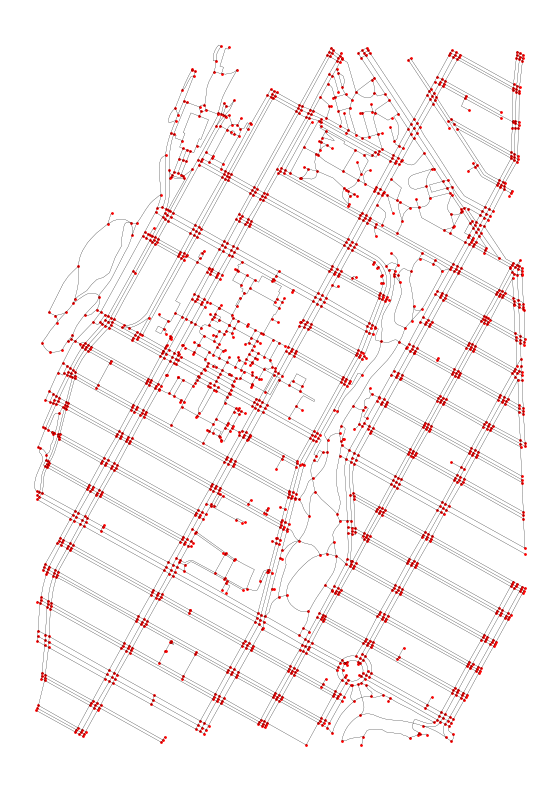

In [31]:
ax = mh_net_edges.plot(color="black", linewidth=0.1, figsize=(10, 10))
mh_net_nodes.plot(ax=ax, color="red", markersize=1).set_axis_off()

In [32]:
avery_hall = Point(-73.9614755, 40.8081037)

### get directions between avery hall and a random restaurant using osmnx


In [33]:
# get the nearest node to avery hall
orig = ox.distance.nearest_nodes(mh_network, avery_hall.x, avery_hall.y)
sample = mh_restaurants.sample(1)
dest = ox.distance.nearest_nodes(mh_network, sample.geometry.x, sample.geometry.y)[0]

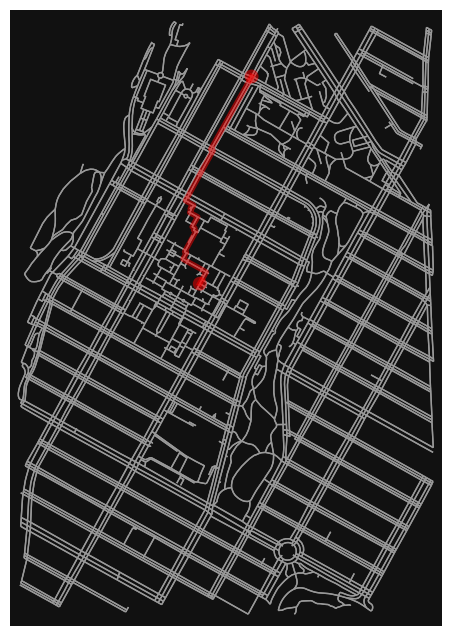

In [34]:
# find the shortest path between nodes, minimizing travel time, then plot it
route = ox.shortest_path(mh_network, orig, dest, weight="length")
fig, ax = ox.plot_graph_route(mh_network, route, node_size=0)

In [35]:
edge_lengths = ox.routing.route_to_gdf(mh_network, route)["length"]

# convert meters to miles
sum(edge_lengths) / 1609.34

0.5086078765208099

In [36]:
mh_pizza = mh_restaurants[mh_restaurants.cuisine_description == "Pizza"]

<Axes: >

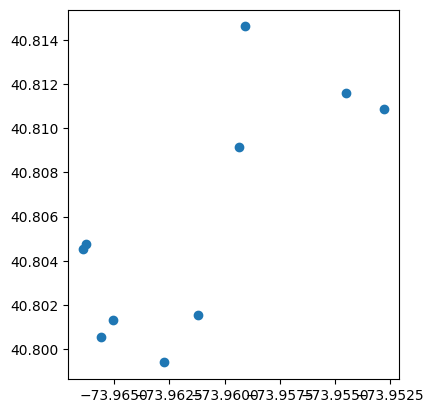

In [37]:
mh_pizza.plot()

In [38]:
def distance_from_point(row, origin):
    """
    Returns the distance in miles and the geometry of the shortest path between a point and a destination.

    Parameters:
    row (pd.Series): A row from a pandas DataFrame.
    origin (int): The origin node in the network.
    """

    dest = ox.distance.nearest_nodes(mh_network, row.geometry.x, row.geometry.y)  # [0]
    route = ox.shortest_path(mh_network, origin, dest, weight="length")
    edge_lengths = ox.routing.route_to_gdf(mh_network, route)["length"]

    route_geom = ox.routing.route_to_gdf(mh_network, route)
    route_geom = route_geom.geometry.unary_union

    return {"distance": sum(edge_lengths) / 1609.34, "route_geom": route_geom}

In [39]:
mh_pizza["distance_from_avery"] = mh_pizza.apply(
    distance_from_point, origin=orig, axis=1
)

/var/folders/p0/n4n30xss14l6w70vvb2pzcd40000gn/T/ipykernel_56457/1794929083.py:15: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  route_geom = route_geom.geometry.unary_union
/var/folders/p0/n4n30xss14l6w70vvb2pzcd40000gn/T/ipykernel_56457/1794929083.py:15: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  route_geom = route_geom.geometry.unary_union
/var/folders/p0/n4n30xss14l6w70vvb2pzcd40000gn/T/ipykernel_56457/1794929083.py:15: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  route_geom = route_geom.geometry.unary_union
/var/folders/p0/n4n30xss14l6w70vvb2pzcd40000gn/T/ipykernel_56457/1794929083.py:15: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  route_geom = route_geom.geometry.unary_union
/var/folders/p0/n4n30xss14l6w70vvb2pzcd40000gn/T/ipykernel_56457/1794929083.

In [40]:
# explode the dictionary into separate columns
mh_pizza = pd.concat(
    [
        mh_pizza.drop(["distance_from_avery"], axis=1),
        mh_pizza["distance_from_avery"].apply(pd.Series),
    ],
    axis=1,
)

In [41]:
mh_pizza_routes = gpd.GeoDataFrame(mh_pizza, geometry="route_geom", crs="EPSG:4326")

Text(0.5, 1.0, 'Distance from Avery Hall to \n Morningside Heights Pizza Restaurants')

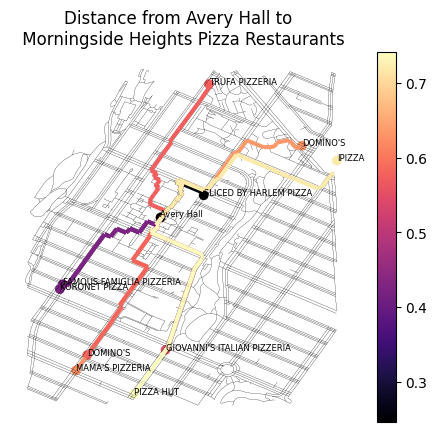

In [42]:
ax = gpd.GeoSeries(avery_hall).plot(color="black")
mh_net_edges.plot(ax=ax, color="black", linewidth=0.1)
mh_pizza_routes.plot(column="distance", cmap="magma", ax=ax, linewidth=3)
mh_pizza.plot(column="distance", cmap="magma", legend=True, ax=ax).set_axis_off()


# label each point
for x, y, label in zip(mh_pizza.geometry.x, mh_pizza.geometry.y, mh_pizza.dba):
    ax.text(x, y, label, fontsize=6)
ax.text(avery_hall.x, avery_hall.y, "Avery Hall", fontsize=6)

# title
plt.title("Distance from Avery Hall to \n Morningside Heights Pizza Restaurants")

In [43]:
mh_pizza[["dba", "distance"]].sort_values("distance")

,dba,distance
161,SLICED BY HARLEM PIZZA,0.246335
21,FAMOUS FAMIGLIA PIZZERIA,0.423456
31,KORONET PIZZA,0.423456
144,GIOVANNI'S ITALIAN PIZZERIA,0.556778
329,TRUFA PIZZERIA,0.573660
157,DOMINO'S,0.579761
122,MAMA'S PIZZERIA,0.630225
52,DOMINO'S,0.633339
617,IPIZZA,0.720308
745,PIZZA HUT,0.740799


<Axes: >

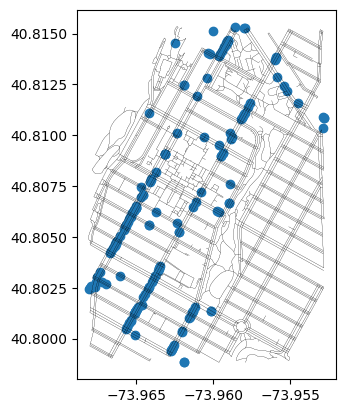

In [44]:
ax = mh_restaurants.plot()
mh_net_edges.plot(ax=ax, color="black", linewidth=0.1)

In [45]:
# use H3 grid to create a hexagon around the restaurants
# count the number of restaurants in each hexagon
# use pysal to get adjacency between hexagons
# build new network with hexagons as nodes and their adjacency as edges
# use networkx to find the shortest path between hexagons

# get the H3 hexagons

In [46]:
mh_net_nodes

,y,x,highway,street_count,geometry
osmid,,,,,
42421737,40.799244,-73.962873,traffic_signals,4,POINT (-73.96287 40.79924)
42421741,40.800429,-73.965691,traffic_signals,4,POINT (-73.96569 40.80043)
42421745,40.801398,-73.967996,traffic_signals,4,POINT (-73.968 40.8014)
42421852,40.812622,-73.956823,traffic_signals,3,POINT (-73.95682 40.81262)
42421857,40.813822,-73.959800,traffic_signals,4,POINT (-73.9598 40.81382)
...,...,...,...,...,...
12029862491,40.808739,-73.965726,crossing,4,POINT (-73.96573 40.80874)
12029862492,40.808069,-73.964123,crossing,4,POINT (-73.96412 40.80807)
12029862493,40.808442,-73.965017,crossing,4,POINT (-73.96502 40.80844)


In [47]:
mh_net_nodes["h3"] = mh_net_nodes.apply(
    lambda x: h3.geo_to_h3(x.geometry.centroid.y, x.geometry.centroid.x, 9), axis=1
)

In [48]:
mh_net_nodes["h3"]

osmid
42421737       892a10088b3ffff
42421741       892a1008887ffff
42421745       892a100888fffff
42421852       892a1008c33ffff
42421857       892a1008c07ffff
                    ...       
12029862491    892a1008c67ffff
12029862492    892a1008c2bffff
12029862493    892a1008c67ffff
12029862494    892a1008c67ffff
12036804275    892a1008d4bffff
Name: h3, Length: 1989, dtype: object

In [49]:
# create hexagons for AOI
mh_net_nodes["geometry"] = mh_net_nodes["h3"].apply(
    lambda x: (h3.h3_to_geo_boundary(x))
)

/var/folders/p0/n4n30xss14l6w70vvb2pzcd40000gn/T/ipykernel_56457/2385662124.py:2: UserWarning: Geometry column does not contain geometry.
  mh_net_nodes["geometry"] = mh_net_nodes["h3"].apply(


In [50]:
# flip order of coordinates for each tuple
mh_net_nodes["geometry"] = mh_net_nodes["geometry"].apply(
    lambda x: Polygon([(y, x) for x, y in x])
)

In [51]:
mh_net_nodes.crs = "EPSG:4326"

In [52]:
mh_net_nodes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [53]:
# mh_net_edges.to_crs("EPSG:2263", inplace=True)
# mh_net_nodes.to_crs("EPSG:2263", inplace=True)

In [54]:
mh_net_nodes

,y,x,highway,street_count,geometry,h3
osmid,,,,,,
42421737,40.799244,-73.962873,traffic_signals,4,"POLYGON ((-73.96198 40.79993, -73.96409 40.798...",892a10088b3ffff
42421741,40.800429,-73.965691,traffic_signals,4,"POLYGON ((-73.96422 40.80251, -73.96633 40.801...",892a1008887ffff
42421745,40.801398,-73.967996,traffic_signals,4,"POLYGON ((-73.9685 40.8024, -73.97061 40.80146...",892a100888fffff
42421852,40.812622,-73.956823,traffic_signals,3,"POLYGON ((-73.95607 40.81332, -73.95818 40.812...",892a1008c33ffff
42421857,40.813822,-73.959800,traffic_signals,4,"POLYGON ((-73.95831 40.8159, -73.96042 40.8149...",892a1008c07ffff
...,...,...,...,...,...,...
12029862491,40.808739,-73.965726,crossing,4,"POLYGON ((-73.96667 40.81039, -73.96878 40.809...",892a1008c67ffff
12029862492,40.808069,-73.964123,crossing,4,"POLYGON ((-73.96239 40.8105, -73.9645 40.80956...",892a1008c2bffff
12029862493,40.808442,-73.965017,crossing,4,"POLYGON ((-73.96667 40.81039, -73.96878 40.809...",892a1008c67ffff


In [55]:
mh_net_nodes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

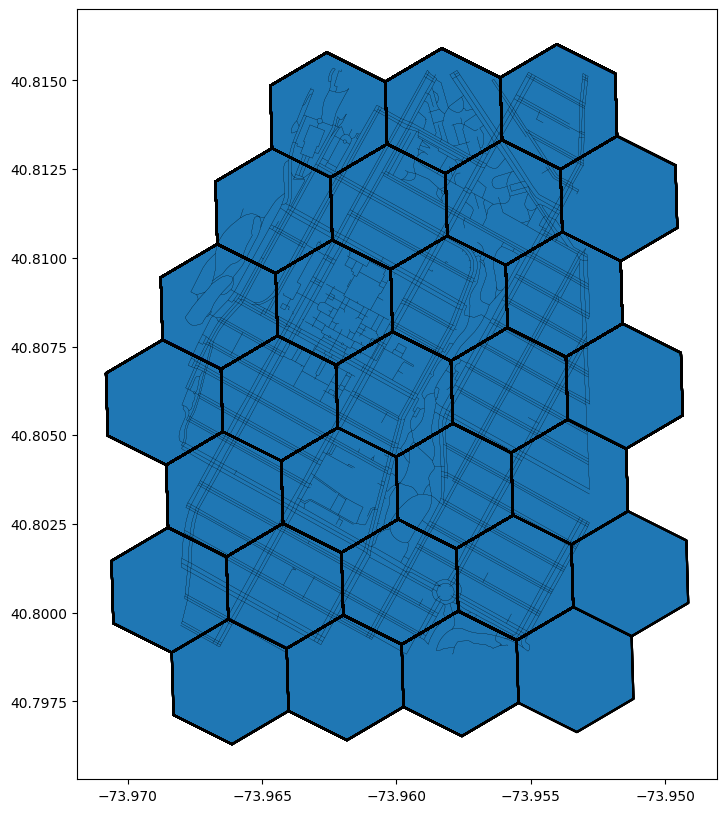

In [56]:
ax = mh_net_nodes.plot(figsize=(10, 10))
mh_net_nodes.boundary.plot(ax=ax, color="black")
mh_net_edges.plot(
    ax=ax,
    color="black",
    linewidth=0.1,
)  # .set_axis_off()

In [57]:
from lonboard import Map, PolygonLayer

In [59]:
layer = PolygonLayer.from_geopandas(
    mh_net_nodes[["geometry"]],
    get_line_color="black",
    get_fill_color="none",
    get_line_width=3,
)
# edges_layer = LineLayer.from_geopandas(
#     mh_net_edges[["geometry"]],
#     get_line_color="black",
#     get_fill_color="none",
#     get_line_width=1,
# )
m = Map(
    [
        layer,
    ]
)
m

Map(layers=[PolygonLayer(get_fill_color=(0, 0, 0, 0), get_line_color=(0, 0, 0, 255), get_line_width=3.0, table…

In [60]:
mh_net_nodes.drop_duplicates(subset="h3", inplace=True)

In [61]:
# create an adjacency matrix for the hexagons
w = lps.weights.Queen.from_dataframe(mh_net_nodes)

/var/folders/p0/n4n30xss14l6w70vvb2pzcd40000gn/T/ipykernel_56457/2435529990.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = lps.weights.Queen.from_dataframe(mh_net_nodes)


In [62]:
# get neighbors for each hexagon
neighbors = {k: v for k, v in w.neighbors.items()}

In [63]:
neighbors

{0: [1, 18, 17, 23],
 1: [0, 2, 18, 6, 23, 12],
 2: [1, 6, 23],
 3: [16, 4, 21, 22, 8, 11],
 4: [8, 3, 5, 22],
 5: [8, 24, 4],
 6: [1, 2, 7, 12, 13],
 7: [19, 6, 25, 27, 12, 13],
 8: [3, 4, 5, 24, 27, 11],
 9: [16, 10, 20],
 10: [16, 19, 20, 9, 11, 15],
 11: [16, 3, 19, 8, 10, 27],
 12: [1, 18, 19, 6, 7, 15],
 13: [25, 6, 7],
 14: [17, 18, 20, 26, 28, 15],
 15: [18, 19, 20, 10, 12, 14],
 16: [3, 21, 9, 10, 11],
 17: [0, 18, 26, 14],
 18: [0, 1, 17, 12, 14, 15],
 19: [7, 27, 10, 11, 12, 15],
 20: [9, 10, 28, 14, 15],
 21: [16, 3, 22],
 22: [3, 4, 21],
 23: [0, 1, 2],
 24: [8, 25, 27, 5],
 25: [24, 27, 13, 7],
 26: [17, 28, 14],
 27: [19, 7, 8, 24, 11, 25],
 28: [26, 20, 14]}

In [64]:
# create networkx graph from adjacency matrix
G = nx.Graph(neighbors)

In [65]:
# get the path between two nodes
path = nx.shortest_path(G, 27, 18)

/var/folders/p0/n4n30xss14l6w70vvb2pzcd40000gn/T/ipykernel_56457/1576104426.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mh_net_nodes.geometry.centroid.x,
/var/folders/p0/n4n30xss14l6w70vvb2pzcd40000gn/T/ipykernel_56457/1576104426.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mh_net_nodes.geometry.centroid.y,


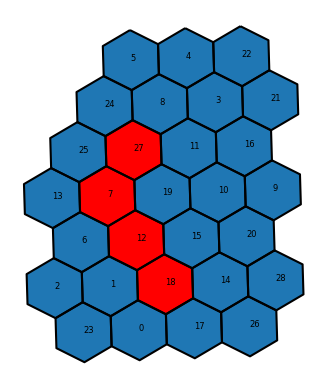

In [66]:
# plot the path
ax = mh_net_nodes.plot()
mh_net_nodes.boundary.plot(ax=ax, color="black")
mh_net_nodes.iloc[path].plot(ax=ax, color="red").set_axis_off()

# label cells with their index
for x, y, label in zip(
    mh_net_nodes.geometry.centroid.x,
    mh_net_nodes.geometry.centroid.y,
    neighbors.keys(),
):
    ax.text(x, y, label, fontsize=6)